<a href="https://colab.research.google.com/github/BaronVonBussin/NewTransit/blob/main/regimeshift_turbulenceindex_20241224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import math
from pykalman import KalmanFilter
from matplotlib import pyplot as plt

In [ ]:
# Date ranges
in_sample_last = '2016-12-31'
in_sample_last_minus_half_year = '2016-07-01'
start_date = '2011-01-01'
end_date = '2019-12-31'

# Load and clean data
vx = pd.read_csv('/content/Daily_VIX.csv')
sp = pd.read_csv('/content/Daily_SPX.csv')
vx.columns = ['date', 'open', 'high', 'low', 'close']
sp.columns = ['date', 'open', 'high', 'low', 'close']

# Set index and sort
vx['date'] = pd.to_datetime(vx['date'])
sp['date'] = pd.to_datetime(sp['date'])
vx.set_index('date', inplace=True)
sp.set_index('date', inplace=True)
vx = vx.sort_index()
sp = sp.sort_index()

# Filter date range
vx = vx[start_date:end_date]
sp = sp[start_date:end_date]

# Get close prices
vx_close = vx['close']
sp_close = sp['close']

# Concatenate to form close price dataframe 'close_df'
close_df = pd.concat([vx_close, sp_close], axis=1)
close_df.columns = ['vx_close', 'sp_close']
close_df = close_df.interpolate(method='linear')

# Calculate returns
vx_return = vx_close.pct_change()
sp_return = sp_close.pct_change()

# Create in-sample sets
vx_close_is = vx_close[vx_close.index <= in_sample_last]
sp_close_is = sp_close[sp_close.index <= in_sample_last]
vx_return_is = vx_return[vx_return.index <= in_sample_last]
sp_return_is = sp_return[sp_return.index <= in_sample_last]

# Create out-of-sample sets
vx_close_os = vx_close[vx_close.index > in_sample_last]
sp_close_os = sp_close[sp_close.index > in_sample_last]
vx_return_os = vx_return[vx_return.index > in_sample_last]
sp_return_os = sp_return[sp_return.index > in_sample_last]

# Print first few values to verify
print("First 5 VIX returns:")
print(vx_return_os.head())
print("\nFirst 5 SPX returns:")
print(sp_return_os.head())

First 5 VIX returns:
date
2017-01-03   -0.084758
2017-01-04   -0.077821
2017-01-05   -0.015190
2017-01-06   -0.029991
2017-01-09    0.021201
Name: close, dtype: float64

First 5 SPX returns:
date
2017-01-03    0.008487
2017-01-04    0.005722
2017-01-05   -0.000771
2017-01-06    0.003517
2017-01-09   -0.003549
Name: close, dtype: float64


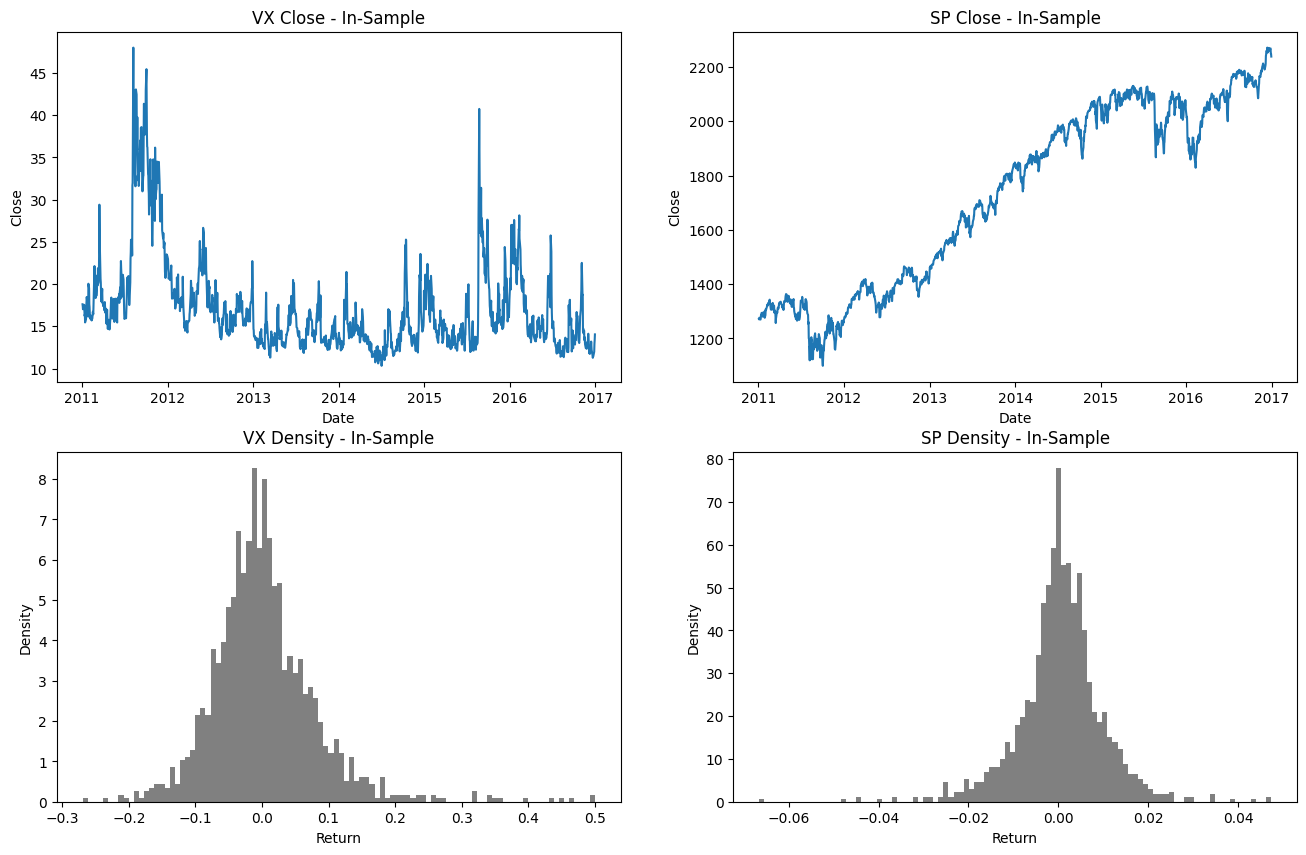

In [ ]:
fig_1 = plt.figure(1, figsize=(16, 10))

#Plotting VX close prices for in-sample period
chart1 = fig_1.add_subplot(221)
chart1.plot(vx_close_is)
chart1.set_ylabel('Close')
chart1.set_xlabel('Date')
chart1.title.set_text('VX Close - In-Sample')

#Plotting SP close prices for in-sample period
chart2 = fig_1.add_subplot(222)
chart2.plot(sp_close_is)
chart2.set_ylabel('Close')
chart2.set_xlabel('Date')
chart2.title.set_text('SP Close - In-Sample')

#Plotting distribution for VX return for in-sample period
chart3 = fig_1.add_subplot(223)
chart3.hist(vx_return_is, density='True', bins=100, label='empirical', color='grey')
chart3.set_ylabel('Density')
chart3.set_xlabel('Return')
chart3.title.set_text('VX Density - In-Sample')

#Plotting distribution for SP return for in-sample period
chart4 = fig_1.add_subplot(224)
chart4.hist(sp_return_is, density='True', bins=100, label='empirical', color='grey')
chart4.set_ylabel('Density')
chart4.set_xlabel('Return')
chart4.title.set_text('SP Density - In-Sample')

plt.show()

<ipython-input-27-cd313c3fe9d9>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([str(p.date()) for p in sp_return_is[::len(sp_return_is)//9].index])


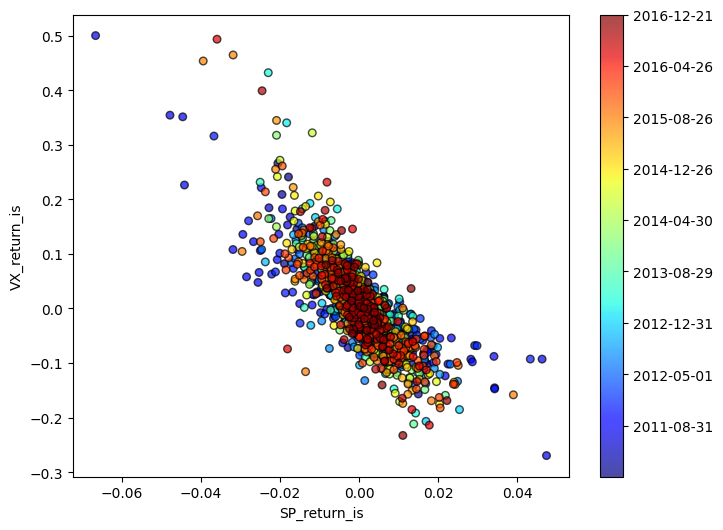

In [ ]:
# Plotting VX return against SP return
plt.figure(figsize=(8,6))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(sp_return_is))
sc = plt.scatter(sp_return_is, vx_return_is, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in sp_return_is[::len(sp_return_is)//9].index])
plt.xlabel('SP_return_is')
plt.ylabel('VX_return_is');

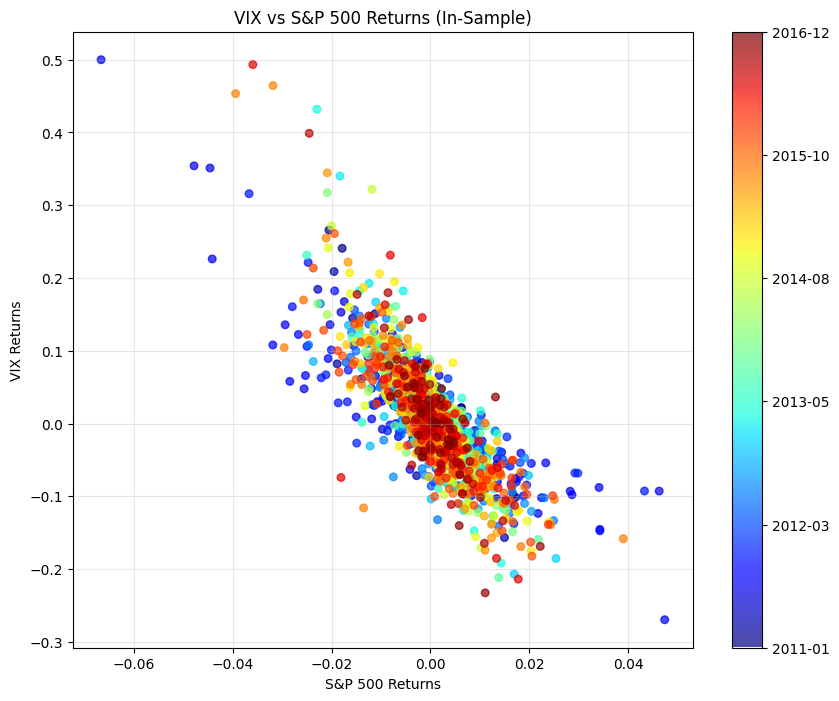

In [ ]:
plt.figure(figsize=(10,8))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(sp_return_is))

sc = plt.scatter(sp_return_is, vx_return_is, s=30, c=colors, cmap=cm, alpha=0.7)
cb = plt.colorbar(sc)

# Fix colorbar ticks and labels
n_ticks = 6
ticks = np.linspace(0.1, 1, n_ticks)
date_indices = np.linspace(0, len(sp_return_is)-1, n_ticks, dtype=int)
date_labels = [sp_return_is.index[i].strftime('%Y-%m') for i in date_indices]

cb.set_ticks(ticks)
cb.set_ticklabels(date_labels)

plt.xlabel('S&P 500 Returns')
plt.ylabel('VIX Returns')
plt.title('VIX vs S&P 500 Returns (In-Sample)')
plt.grid(True, alpha=0.3)

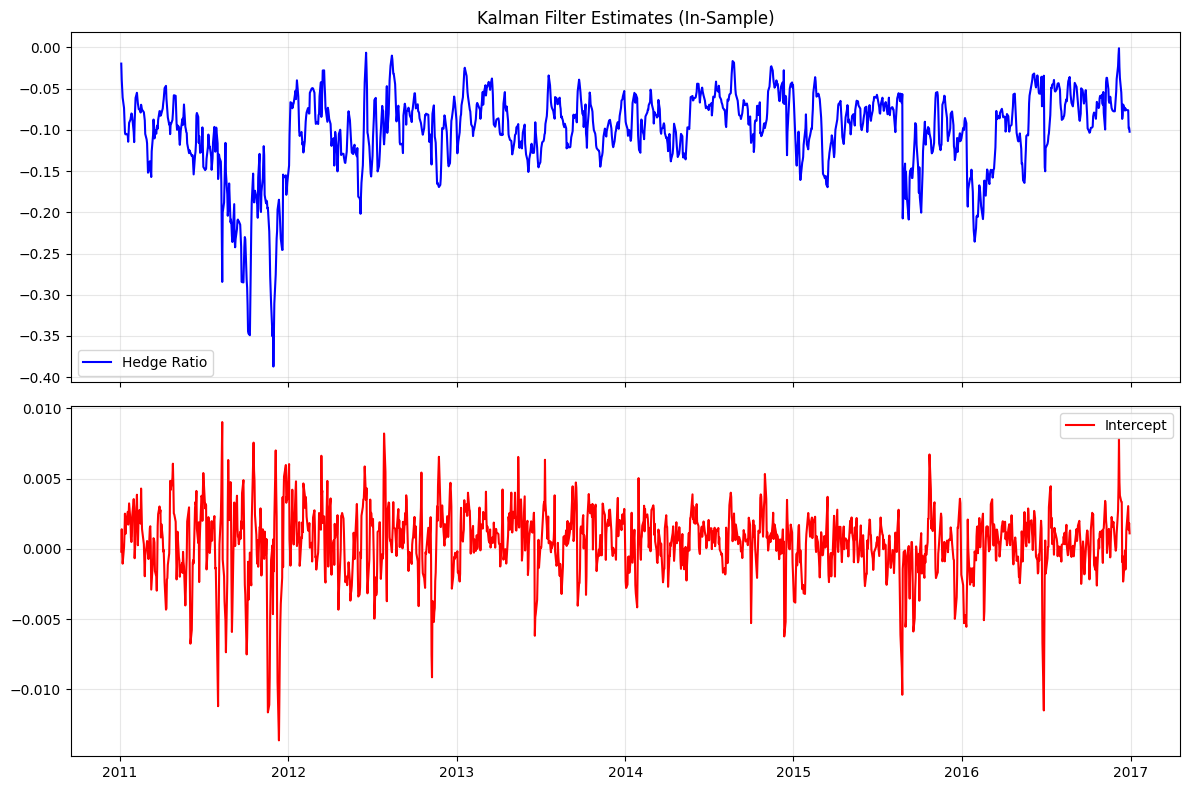

In [ ]:
# Remove NaN values
mask = ~(pd.isna(vx_return_is) | pd.isna(sp_return_is))
vx_return_clean = vx_return_is[mask]
sp_return_clean = sp_return_is[mask]

# Setup KalmanFilter
kf_is = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    transition_matrices=np.eye(2),
    observation_matrices=np.expand_dims(np.vstack([[vx_return_clean], [np.ones(len(vx_return_clean))]]).T, axis=1),
    em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance']
)

# EM estimation and smoothing
state_means_is, state_covs_is = kf_is.em(sp_return_clean).smooth(sp_return_clean)

# Plot
fig, axarr = plt.subplots(2, figsize=(12,8), sharex=True)
axarr[0].plot(vx_return_clean.index, state_means_is[:,0], 'b-', label='Hedge Ratio')
axarr[1].plot(vx_return_clean.index, state_means_is[:,1], 'r-', label='Intercept')

for ax in axarr:
    ax.grid(True, alpha=0.3)
    ax.legend()

axarr[0].set_title('Kalman Filter Estimates (In-Sample)')
plt.tight_layout()

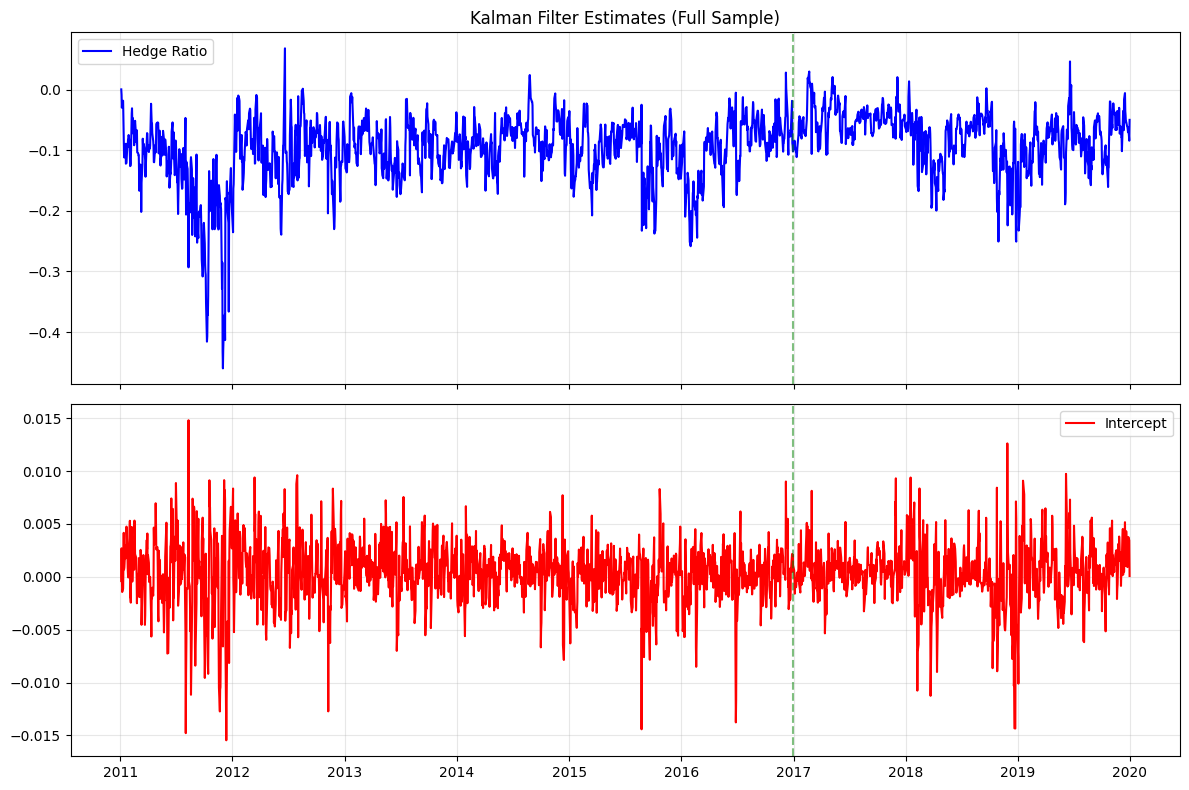

In [ ]:
# Remove NaN values
mask = ~(pd.isna(vx_return) | pd.isna(sp_return))
vx_return_clean = vx_return[mask]
sp_return_clean = sp_return[mask]

# Out of sample estimation
kf = KalmanFilter(
   n_dim_obs=1,
   n_dim_state=2,
   initial_state_mean=np.zeros(2),
   transition_matrices=np.eye(2),
   observation_matrices=np.expand_dims(np.vstack([[vx_return_clean], [np.ones(len(vx_return_clean))]]).T, axis=1),
   em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance']
)

# EM with in-sample, filter with full data
state_means, state_covs = kf.em(sp_return_clean[sp_return_clean.index <= in_sample_last]).filter(sp_return_clean)

# Plot
fig, axarr = plt.subplots(2, figsize=(12,8), sharex=True)
axarr[0].plot(vx_return_clean.index, state_means[:,0], 'b-', label='Hedge Ratio')
axarr[1].plot(vx_return_clean.index, state_means[:,1], 'r-', label='Intercept')

# Add vertical line at in-sample cutoff
cutoff_date = pd.to_datetime(in_sample_last)
for ax in axarr:
   ax.axvline(x=cutoff_date, color='g', linestyle='--', alpha=0.5)
   ax.grid(True, alpha=0.3)
   ax.legend()

axarr[0].set_title('Kalman Filter Estimates (Full Sample)')
plt.tight_layout()

In [ ]:
# Create hedge ratio dataframe
hedge_ratio = pd.DataFrame(state_means[:,0], index=vx_return_clean.index, columns=['hedge_ratio'])
hedge_ratio_os = hedge_ratio[hedge_ratio.index > in_sample_last]

# Shift hedge ratios and returns
hedge_ratio_os_shifted = hedge_ratio_os.shift(1).dropna()
vx_return_os_shifted = vx_return_os.shift(-1)
sp_return_os_shifted = sp_return_os.shift(-1)

# Combine into final dataframe
os_df = pd.DataFrame({
   'hedge_ratio': hedge_ratio_os_shifted['hedge_ratio'],
   'vx_return': vx_return_os_shifted,
   'sp_return': sp_return_os_shifted
}).dropna()

# Add cumulative return
os_df['sp_cumulative_return'] = os_df['sp_return'].cumsum()

print(os_df.head())

            hedge_ratio  vx_return  sp_return  sp_cumulative_return
date                                                               
2017-01-04    -0.093847  -0.015190  -0.000771             -0.000771
2017-01-05    -0.084404  -0.029991   0.003517              0.002746
2017-01-06    -0.089351   0.021201  -0.003549             -0.000802
2017-01-09    -0.094840  -0.006055   0.000000             -0.000802
2017-01-10    -0.104216  -0.020017   0.002830              0.002027


In [ ]:
os_df.to_excel('os_df.xlsx')
sp_return[sp_return.index >= in_sample_last_minus_half_year].to_csv('SP_Return_os.csv')

In [ ]:
# Load turbulence data
turb = pd.read_csv('turbulence_index.csv', index_col=0)
turb.index = pd.to_datetime(turb.index)
turb.columns = ['turb_close']  # Rename Close to turb_close

# Join with close_df
close_df = close_df.join(turb['turb_close'], how='left')
close_df.fillna(method='ffill', inplace=True)
close_df['turb_close'] = close_df['turb_close'].interpolate(method='linear')

# Split into in/out sample
turb_close = close_df['turb_close']
turb_close_is = turb_close[turb_close.index <= in_sample_last]
turb_close_os = turb_close[turb_close.index > in_sample_last]

print(turb_close_os.head())

date
2017-01-03    1.723969
2017-01-04    3.596175
2017-01-05    2.093593
2017-01-06    1.456104
2017-01-09    2.988820
Name: turb_close, dtype: float64


<ipython-input-33-4e78136f0a39>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_df.fillna(method='ffill', inplace=True)


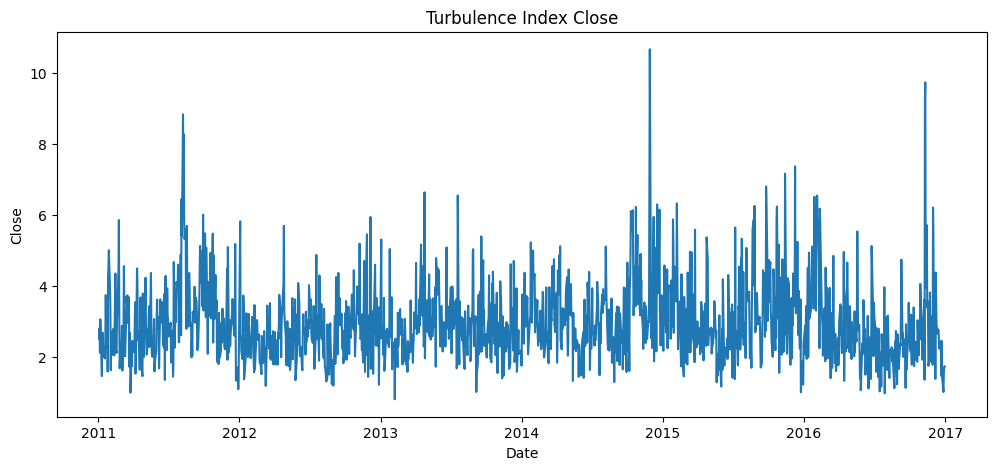

In [ ]:
fig_2 = plt.figure(2, figsize=(12, 5))

chart5 = fig_2.add_subplot(111)
chart5.plot(turb_close_is)
chart5.set_ylabel('Close')
chart5.set_xlabel('Date')
chart5.title.set_text('Turbulence Index Close')

In [ ]:
def forward_algo(v, mu, sigma, a, initial_distribution):
    T = len(v)
    b = np.zeros((T, 2))

    for t in range(T):
        b[t, 0] = np.exp(-0.5 * ((v[t]-mu[0][0])/sigma[0][0])**2)/np.sqrt(2*math.pi)/sigma[0][0]
        b[t, 1] = np.exp(-0.5 * ((v[t]-mu[0][1])/sigma[0][1])**2)/np.sqrt(2*math.pi)/sigma[0][1]

    forward = np.zeros((v.shape[0], a.shape[0]))
    scale = np.zeros((v.shape[0], a.shape[0]))
    forward[0, :] = b[0, :] * initial_distribution
    scale[0, :] = np.sum(forward[0, :])
    forward[0, :] = forward[0, :]/np.sum(forward[0, :])
    for t in range(1, T):
        forward[t, :] = forward[t-1, :].dot(a) * b[t, :]
        scale[t, :] = np.sum(forward[t, :])
        forward[t, :] = forward[t, :]/np.sum(forward[t, :])

    return(forward)


def baum_welch(v, mu, sigma, a, initial_distribution):
    T = len(v)
    b = np.zeros((T, 2))

    likelihood = -999
    change_likelihood = 999
    tolerance = 0.001

    while change_likelihood > tolerance:
        for t in range(T):
            b[t, 0] = np.exp(-0.5 * ((v[t]-mu[0][0])/sigma[0][0])**2)/np.sqrt(2*math.pi)/sigma[0][0]
            b[t, 1] = np.exp(-0.5 * ((v[t]-mu[0][1])/sigma[0][1])**2)/np.sqrt(2*math.pi)/sigma[0][1]

        forward = np.zeros((v.shape[0], a.shape[0]))
        scale = np.zeros((v.shape[0], a.shape[0]))
        forward[0, :] = b[0, :] * initial_distribution
        scale[0, :] = np.sum(forward[0, :])
        forward[0, :] = forward[0, :]/np.sum(forward[0, :])
        for t in range(1, T):
            forward[t, :] = forward[t-1, :].dot(a) * b[t, :]
            scale[t, :] = np.sum(forward[t, :])
            forward[t, :] = forward[t, :]/np.sum(forward[t, :])

        backward = np.zeros((v.shape[0], a.shape[0]))
        backward[-1, :] = b[-1: ]
        backward[-1, :] = backward[-1, :]/sum(backward[-1, :])
        for t in range(T-2, -1, -1):
            backward[t, :] = (a.dot(backward[t+1, :].T)).T * b[t+1, :]
            backward[t, :] = backward[t, :]/np.sum(backward[t, :])

        smoothed = np.zeros((v.shape[0], a.shape[0]))
        for t in range(T):
            smoothed[t, :] = forward[t, :] * backward[t, :]
            smoothed[t, :] = smoothed[t, :]/np.sum(smoothed[t, :])

        xi = np.zeros((2, 2, T-1))
        for t in range(T-1):
            xi[:, :, t] = a * (np.array([forward[t, :]]).T.dot(np.array([backward[t+1, :] * b[t+1, :]])))
            xi[:, :, t] = xi[:, :, t]/np.sum(np.sum(xi[:, :, t], axis=1))

        p = smoothed[0, :]
        exp_num_transition = np.sum(xi, axis=2)
        a[0, :] = exp_num_transition[0, :]/np.sum(smoothed[1:T, :])
        a[1, :] = exp_num_transition[1, :]/np.sum(smoothed[1:T, :])
        mu[0][0] = (smoothed[:, 0].T.dot(v)).T/np.sum(smoothed[:, 0])
        mu[0][1] = (smoothed[:, 1].T.dot(v)).T/np.sum(smoothed[:, 1])
        sigma[0][0] = np.sqrt(np.sum(smoothed[:, 0] * (v-mu[0][0]) ** 2)/np.sum(smoothed[:, 0]))
        sigma[0][1] = np.sqrt(np.sum(smoothed[:, 1] * (v-mu[0][1]) ** 2)/np.sum(smoothed[:, 1]))

        tmp_likelihood = np.sum(np.sum(np.log(scale)))
        change_likelihood = np.abs(tmp_likelihood - likelihood)
        likelihood = tmp_likelihood

    return mu, sigma, a


In [ ]:
# Calibrating the Markow Switching Model using the Baum Welch Algorithm
v = turb_close_is.values
mu = np.mean(v) + np.std(v) * np.random.randn(1,2)
sigma = np.zeros((1,2)) + np.std(v)
a = np.ones((2, 2))
a = a / np.sum(a, axis=1)
initial_distribution = np.array((0.5, 0.5))
mu_bw, sigma_bw, a_bw = baum_welch(v, mu, sigma, a, initial_distribution)

# Infer the probabilities for high volatility regime and low volatility regime using the Forward Algorithm
regime_prob_array = forward_algo(turb_close.values, mu_bw, sigma_bw, a_bw, initial_distribution)
regime_prob_df = pd.DataFrame(regime_prob_array, index=turb_close.index)
regime_prob_df.columns = ['Regime_0', 'Regime_1']
regime_prob_df = regime_prob_df.join(turb_close, how='left')

# Simply to find out whether regime_0 or regime_1 correpsonds to the high volatility regime
signal = regime_prob_df['Regime_0'] > regime_prob_df['Regime_1']
if (regime_prob_df['turb_close'][signal]).mean() > (regime_prob_df['turb_close'][~signal]).mean():
    regime_prob_df['hmm_signal'] = signal
else:
    regime_prob_df['hmm_signal'] = ~signal

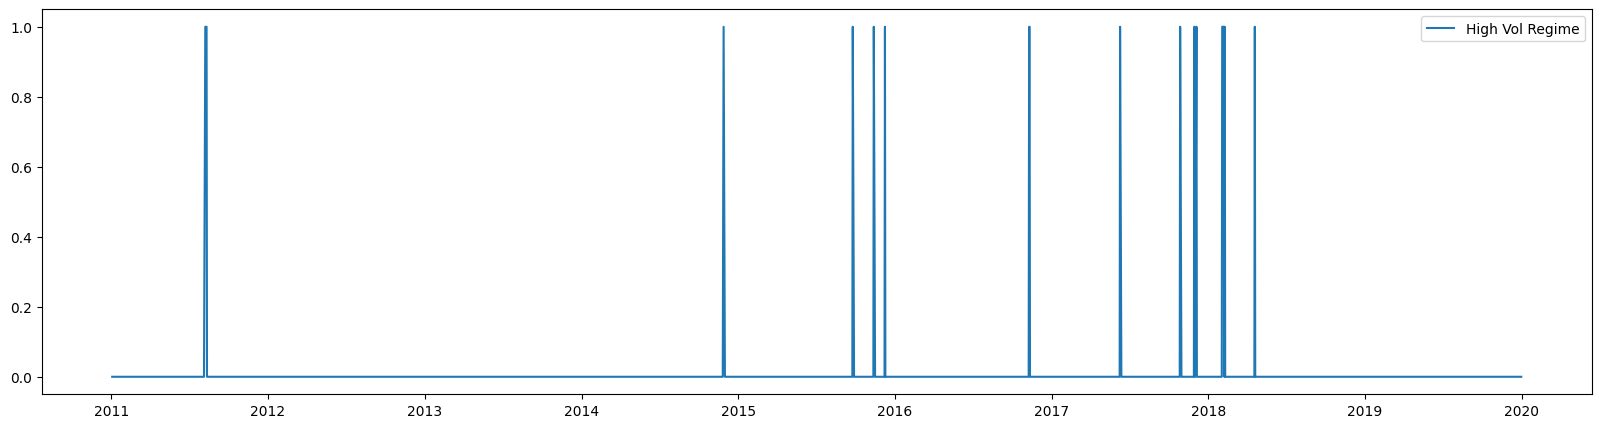

In [ ]:
regime_prob_df.columns
plt.figure(figsize=(20,5))
plt.plot(regime_prob_df['hmm_signal'], label='High Vol Regime')
plt.legend(loc="upper right")

In [ ]:
# Regime signal generated on Jan-02 is used for trading on Jan-03
hmm_signal = regime_prob_df['hmm_signal'].shift(1)
hmm_signal = hmm_signal.dropna()

sp_close.name = 'sp_close' # Added to explicitly name the series
hmm_signal.name = 'hmm_signal_new' #Added to give new name to the series
turb_close.name = 'turb_close' # Added to explicitly name the series
os_df = os_df.join(hmm_signal).join(sp_close).join(turb_close)
os_df = os_df
os_df.head()
#os_dd.describe()

ValueError: columns overlap but no suffix specified: Index(['hmm_signal_new'], dtype='object')

KeyError: 'hmm_signal'

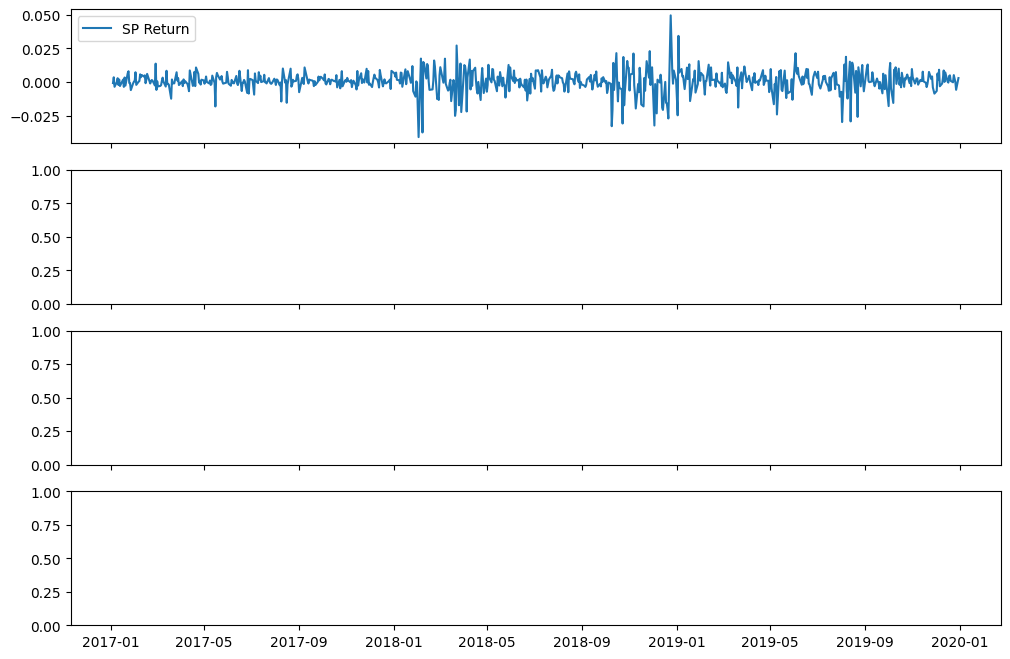

In [ ]:
_, axarr = plt.subplots(4, sharex=True, figsize=(12,8))

# Plotting daily return for S&P 500 Futures
axarr[0].plot(os_df.index, os_df['sp_return'], label='SP Return')
axarr[0].legend(loc='upper left')

# Plotting regime signal generated from HMM model
axarr[1].plot(os_df.index, os_df['hmm_signal'], label='High Vol Regime')
axarr[1].legend(loc='upper left')

# Plotting Turbulence Index
axarr[2].plot(os_df.index, os_df['turb_close'], label='Turbulence Index')
axarr[2].legend(loc='upper left')

# Plotting close price for S&P 500 Futures
axarr[3].plot(os_df.index, os_df['sp_close'], label='SP Close')
axarr[3].legend(loc='upper left')

plt.show()

In [ ]:
# Calculating strategy return
os_df['hmm_strategy_return'] = os_df['sp_return'] - os_df['hmm_signal'] * os_df['hedge_ratio'] * os_df['vx_return']
os_df['hmm_strategy_cumulative_return'] = os_df['hmm_strategy_return'].cumsum()

# PLotting cummulative return for HMM strategy against benchmark portfolio of longing S&P 500 Futures
fig_2 = plt.figure(1, figsize=(8, 5))

chart5 = fig_2.add_subplot(111)
chart5.plot(os_df['hmm_strategy_cumulative_return'], label='HMM Strategy')
chart5.plot(os_df['sp_cumulative_return'], label='sp')
chart5.set_ylabel('Cum Return')
chart5.set_xlabel('Date')
chart5.title.set_text('Strategy Cumulative Return')
chart5.legend(loc='upper right', fontsize=10)
plt.show()

KeyError: 'hmm_signal'

In [ ]:
from scipy.stats import norm
from datetime import datetime

def detect_change_points(data, window=60, threshold=0.95):
   n = len(data)
   lr_stats = np.zeros(n)
   change_points = []
   detection_points = []

   for i in range(window, n-window):
       # Get windows
       window1 = data[i-window:i]
       window2 = data[i:i+window]

       # Calculate likelihood ratio
       mu1, std1 = window1.mean(), window1.std()
       mu2, std2 = window2.mean(), window2.std()

       lr = abs(norm.logpdf(window2, mu1, std1).sum() -
               norm.logpdf(window2, mu2, std2).sum())
       lr_stats[i] = lr

       # Detect change point
       # Check if the slice is empty
       if len(lr_stats[window:i]) > 0:
           if lr > np.quantile(lr_stats[window:i], threshold):
                # Record change point
                change_points.append(i)
                # Record detection point (delay by window)
                detection_points.append(i + window)

   return change_points, detection_points

# Load turbulence data
turb = pd.read_csv('turbulence_index.csv', index_col=0)
turb.index = pd.to_datetime(turb.index)

# Detect changes
change_points, detection_points = detect_change_points(turb['Close'].values)

# Save results
pd.DataFrame(change_points).to_csv('Change_Time.csv', index=False)
pd.DataFrame(detection_points).to_csv('Detection_Time.csv', index=False)

In [ ]:
change_time = pd.read_csv('Change_Time.csv')
change_time.columns = ['Change Time']

detection_time = pd.read_csv('Detection_Time.csv')
detection_time.columns = ['Detection Time']

change_point = pd.concat([change_time, detection_time], axis=1)
change_point

,Change Time,Detection Time
0,62,122
1,64,124
2,67,127
3,70,130
4,89,149
...,...,...
364,5536,5596
365,5537,5597
366,5538,5598
367,5539,5599


In [ ]:
sp_return = pd.read_csv('SP_Return_os.csv', index_col=0, header=0)
sp_return.columns = ['Return']
sp_return['Return'] = pd.to_numeric(sp_return['Return']) # Convert 'Return' column to numeric
print(sp_return.iloc[48:54], '\n')

print('Variance of returns for row 52-54 = ', sp_return.iloc[51:54].values.var())
print('Variance of returns for row 49-51 = ', sp_return.iloc[48:51].values.var())
print('Variance change = ', sp_return.iloc[51:54].values.var()/sp_return.iloc[48:51].values.var())

              Return
date                
2016-09-09 -0.024522
2016-09-12  0.014677
2016-09-13 -0.014831
2016-09-14 -0.000588
2016-09-15  0.010109
2016-09-16 -0.003772 

Variance of returns for row 52-54 =  3.525146043939383e-05
Variance of returns for row 49-51 =  0.00027791129868586574
Variance change =  0.12684428667018668


In [ ]:
## Code for implementing the idea in the above tap

i = 0
action = 2
j = 0

hedge_signal_arr = []
var_change_arr = []

while j < len(sp_return):
    if i < len(change_point) and j < change_point.iloc[i].loc['Detection Time']:
        hedge_signal_arr.append(action)
    elif i < len(change_point):
        detection_time_tmp = change_point.iloc[i].loc['Detection Time']
        change_time_tmp = change_point.iloc[i].loc['Change Time']
        offset = min(5, detection_time_tmp - change_time_tmp)
        var_change = sp_return.iloc[change_time_tmp:(change_time_tmp + offset)].var() / sp_return.iloc[change_time_tmp - offset:change_time_tmp].var()
        var_change_arr.append(var_change)
        if var_change.values[0] >= 1:
            action = 1
        else:
            action = 0
        hedge_signal_arr.append(action)
        i = i + 1
    else:
        hedge_signal_arr.append(action)
    j = j + 1


while j < len(sp_return):
    hedge_signal_arr.append(action)
    j = j + 1

In [ ]:
hedge_signal_changepoint_df = pd.DataFrame(hedge_signal_arr, index=sp_return.index, columns=['change_point_signal'])
var_change_df = pd.DataFrame(var_change_arr)
var_change_df.columns = ['variance change']

print(var_change_df, '\n')

print(hedge_signal_changepoint_df[48:55])

    variance change
0          0.921276
1          0.189427
2          0.858295
3          1.547219
4         10.167217
..              ...
76         9.374207
77        13.364158
78        10.453437
79         4.260994
80         0.190624

[81 rows x 1 columns] 

            change_point_signal
date                           
2016-09-09                    2
2016-09-12                    2
2016-09-13                    2
2016-09-14                    2
2016-09-15                    2
2016-09-16                    2
2016-09-19                    2


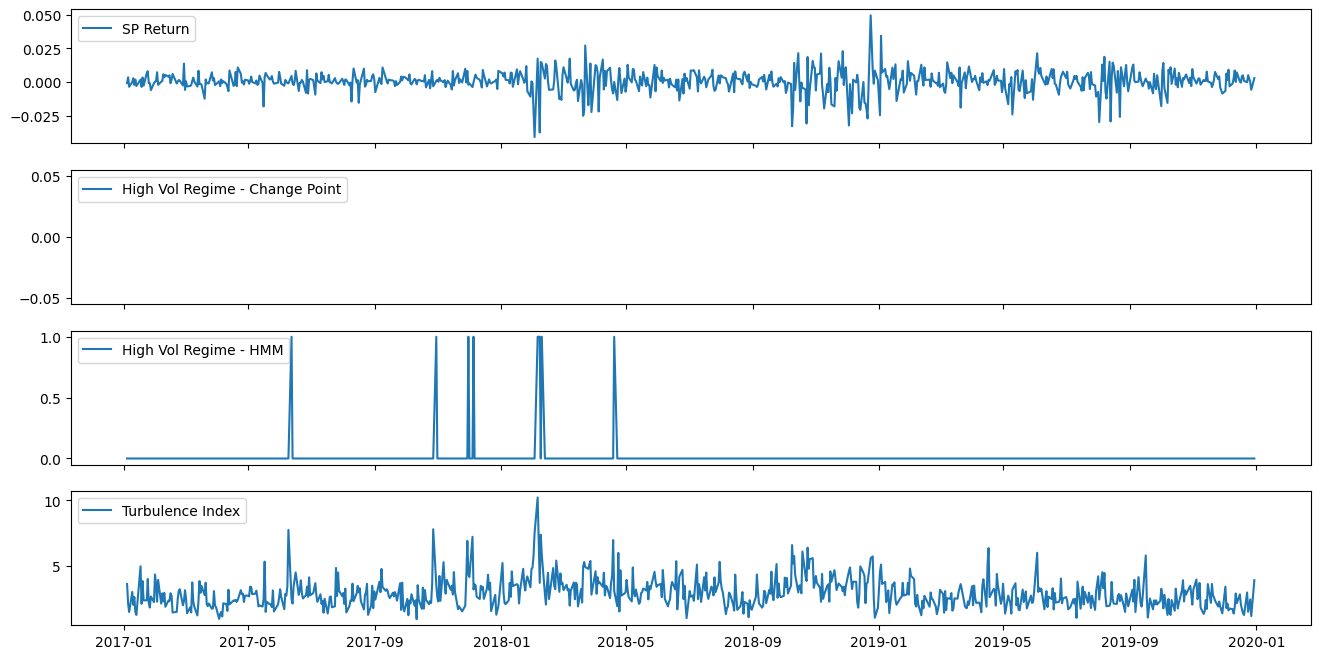

In [ ]:
os_df = os_df.join(hedge_signal_changepoint_df)

_, axarr = plt.subplots(4, sharex=True, figsize=(16,8))
axarr[0].plot(os_df.index, os_df['sp_return'], label='SP Return')
axarr[0].legend(loc='upper left')
axarr[1].plot(os_df.index, os_df['change_point_signal'], label='High Vol Regime - Change Point')
axarr[1].legend(loc='upper left')
axarr[2].plot(os_df.index, os_df['hmm_signal'], label='High Vol Regime - HMM')
axarr[2].legend(loc='upper left')
axarr[3].plot(os_df.index, os_df['turb_close'], label='Turbulence Index')
axarr[3].legend(loc='upper left')
plt.show()

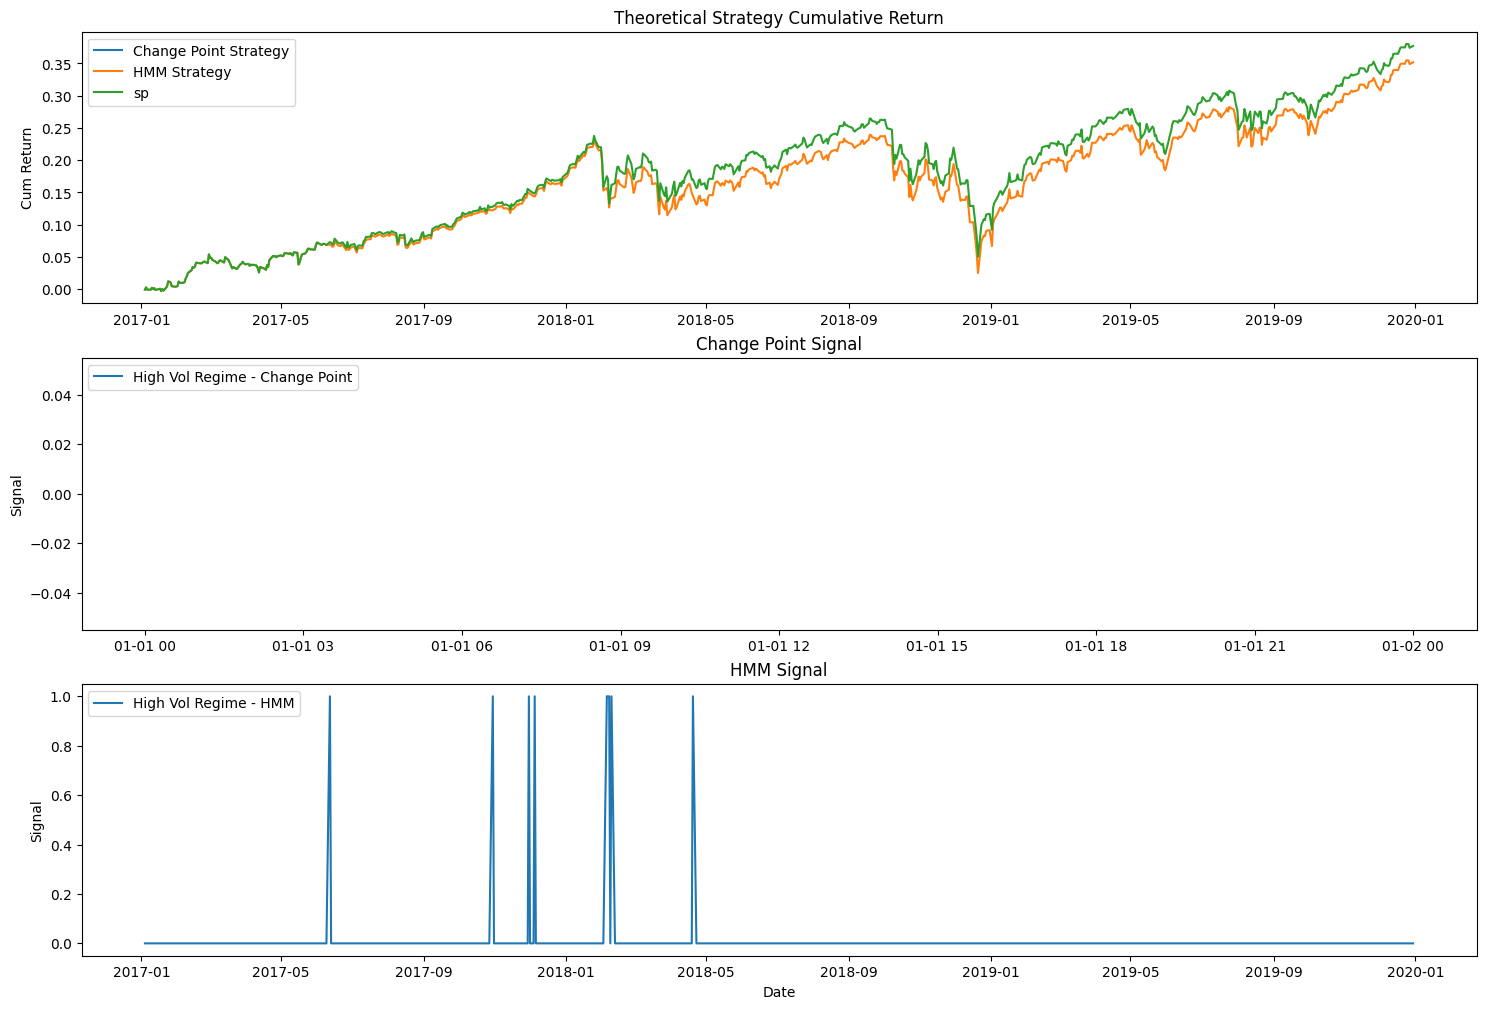

In [ ]:
os_df['change_point_strategy_return'] = os_df['sp_return'] - os_df['change_point_signal'] * os_df['hedge_ratio'] * os_df['vx_return']
os_df['change_point_strategy_cumulative_return'] = os_df['change_point_strategy_return'].cumsum()

fig_3 = plt.figure(1, figsize=(18, 12))
chart6 = fig_3.add_subplot(311)
chart6.plot(os_df['change_point_strategy_cumulative_return'], label='Change Point Strategy')
chart6.plot(os_df['hmm_strategy_cumulative_return'], label='HMM Strategy')
chart6.plot(os_df['sp_cumulative_return'], label='sp')
chart6.set_ylabel('Cum Return')
chart6.title.set_text('Theoretical Strategy Cumulative Return')
chart6.legend(loc='upper left', fontsize=10)

chart7 = fig_3.add_subplot(312)
chart7.plot(os_df['change_point_signal'], label='High Vol Regime - Change Point')
chart7.set_ylabel('Signal')
chart7.title.set_text('Change Point Signal')
chart7.legend(loc='upper left', fontsize=10)

chart8 = fig_3.add_subplot(313)
chart8.plot(os_df['hmm_signal'], label='High Vol Regime - HMM')
chart8.set_ylabel('Signal')
chart8.set_xlabel('Date')
chart8.title.set_text('HMM Signal')
chart8.legend(loc='upper left', fontsize=10)

plt.show()

In [ ]:
trade_change_point_df = os_df[['hedge_ratio', 'change_point_signal']]
trade_change_point_df = trade_change_point_df.join(vx_close_os, how='left')
trade_change_point_df.columns = ['hedge_ratio', 'change_point_signal', 'vx_close']

trade_change_point_df = trade_change_point_df.join(sp_close_os, how='left')
trade_change_point_df.columns = ['hedge_ratio', 'change_point_signal', 'vx_close', 'sp_close']

trade_change_point_df.head()

,hedge_ratio,change_point_signal,vx_close,sp_close
date,,,,
2017-01-04 00:00:00,-0.093847,NaN,11.85,2270.75
2017-01-05 00:00:00,-0.084404,NaN,11.67,2269.00
2017-01-06 00:00:00,-0.089351,NaN,11.32,2276.98
2017-01-09 00:00:00,-0.094840,NaN,11.56,2268.90
2017-01-10 00:00:00,-0.104216,NaN,11.49,2268.90


In [ ]:
trade_change_point_dict = {}
previous_arr = []
initial_cap = 10000000

for idx, row in trade_change_point_df.iterrows():
    hedge_signal = row['change_point_signal']
    target_hedge_ratio = row['hedge_ratio'] * hedge_signal * -1

    if idx == trade_change_point_df.index[0]:
        if pd.isna(target_hedge_ratio): # Check if target_hedge_ratio is NaN
            vx_target_value = 0
            sp_target_value = 0
        else:
            vx_target_value = int(initial_cap * target_hedge_ratio/(1 + np.abs(target_hedge_ratio)))
            sp_target_value = int(initial_cap / (1 + np.abs(target_hedge_ratio)))

        vx_target_num = int(vx_target_value / row['vx_close'] / 1000)
        sp_mini_target_num = int(sp_target_value / row['sp_close'] / 50)

        vx_position_num = vx_target_num
        sp_mini_position_num = sp_mini_target_num

        vx_position_change = vx_target_num
        sp_mini_position_change = sp_mini_target_num

        vx_position_value = vx_position_num * row['vx_close'] * 1000
        sp_mini_position_value = sp_mini_position_num * row['sp_close'] * 50
        cost = 14.6 * np.abs(sp_mini_position_change) + 52.36 * np.abs(vx_position_change) + \
               0.125/10000 * (np.abs(vx_position_change) * row['vx_close'] * 1000 + np.abs(sp_mini_position_change) * row['sp_close'] * 50)
        cash = initial_cap - vx_position_value - sp_mini_position_value - cost

        if (vx_position_value + sp_mini_position_value) == 0 or pd.isna(vx_position_value) or pd.isna(sp_mini_position_value):
            current_hedge_ratio = 0
        else:
            current_hedge_ratio = vx_position_value/(vx_position_value + sp_mini_position_value)

        trade_change_point_dict[idx] = [target_hedge_ratio, hedge_signal, current_hedge_ratio, vx_target_value, sp_target_value, vx_target_num, \
                                        sp_mini_target_num, vx_position_num, sp_mini_position_num, vx_position_change, sp_mini_position_change, \
                                        vx_position_value, sp_mini_position_value, cost, cash, portfolio_nav]
        previous_arr = trade_change_point_dict[idx]

    else:

        if (np.abs(previous_arr[7] * row['vx_close'] * 1000) + np.abs(previous_arr[8] * row['sp_close'] * 50)) == 0 or pd.isna(previous_arr[7]) or pd.isna(row['vx_close']) or pd.isna(previous_arr[8]) or pd.isna(row['sp_close']):
            current_hedge_ratio = 0
        else:
           current_hedge_ratio = previous_arr[7] * row['vx_close'] * 1000 / (np.abs(previous_arr[7] * row['vx_close'] * 1000) + np.abs(previous_arr[8] * row['sp_close'] * 50))
        available_capital = previous_arr[-2] + previous_arr[7] * row['vx_close'] * 1000 + previous_arr[8] * row['sp_close'] * 50

        if target_hedge_ratio == 0:
            vx_target_value = np.nan
            sp_mini_target_value = np.nan
            vx_target_num = np.nan
            sp_mini_target_num = np.nan

            vx_position_change = -1 * previous_arr[7]
            vx_position_num = 0

            sp_mini_position_num = int(available_capital/row['sp_close']/50)
            sp_mini_position_change = sp_mini_position_num - previous_arr[8]

        else:
            if np.abs(current_hedge_ratio - target_hedge_ratio) > 0.03:
                if pd.isna(target_hedge_ratio):
                    vx_target_value = 0
                    sp_target_value = 0
                else:
                    vx_target_value = int(available_capital * target_hedge_ratio/(1 + np.abs(target_hedge_ratio)))
                    sp_target_value = int(available_capital / (1 + np.abs(target_hedge_ratio)))

                vx_target_num = int(vx_target_value / row['vx_close'] / 1000)
                sp_mini_target_num = int(sp_target_value / row['sp_close'] / 50)

                vx_position_num = vx_target_num
                sp_mini_position_num = sp_mini_target_num

                vx_position_change = vx_position_num - previous_arr[7]
                sp_mini_position_change = sp_mini_position_num - previous_arr[8]

            else:
                vx_target_value = np.nan
                sp_mini_target_value = np.nan
                vx_target_num = np.nan
                sp_mini_target_num = np.nan

                vx_position_num = previous_arr[7]
                vx_position_change = 0

                sp_mini_position_num = previous_arr[8]
                sp_mini_position_change = 0


        vx_position_value = vx_position_num * row['vx_close'] * 1000
        sp_mini_position_value = sp_mini_position_num * row['sp_close'] * 50
        cost = 14.6 * np.abs(sp_mini_position_change) + 52.36 * np.abs(vx_position_change) + \
                0.125/10000 * (np.abs(vx_position_change) * row['vx_close'] * 1000 + np.abs(sp_mini_position_change) * row['sp_close'] * 50)
        cash = previous_arr[-2] - vx_position_change * row['vx_close'] * 1000 - sp_mini_position_change * row['sp_close'] * 50

        if (np.abs(vx_position_value) + np.abs(sp_mini_position_value)) == 0 or pd.isna(vx_position_value) or pd.isna(sp_mini_position_value):
            current_hedge_ratio = 0
        else:
            current_hedge_ratio = vx_position_value/(np.abs(vx_position_value) + np.abs(sp_mini_position_value))

        portfolio_nav = vx_position_value + sp_mini_position_value + cash

        trade_change_point_dict[idx] = [target_hedge_ratio, hedge_signal, current_hedge_ratio, vx_target_value, sp_target_value, vx_target_num, sp_mini_target_num, \
                                        vx_position_num, sp_mini_position_num, vx_position_change, sp_mini_position_change, \
                                        vx_position_value, sp_mini_position_value, cost, cash, portfolio_nav]

        previous_arr = trade_change_point_dict[idx]

<ipython-input-59-cc1d4dd98992>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown_arr.append(trade_change_point_backtest['portfolio_nav'][i]/max_nav - 1)
<ipython-input-59-cc1d4dd98992>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown_arr.append(trade_change_point_backtest['benchmark_nav'][i]/max_nav - 1)


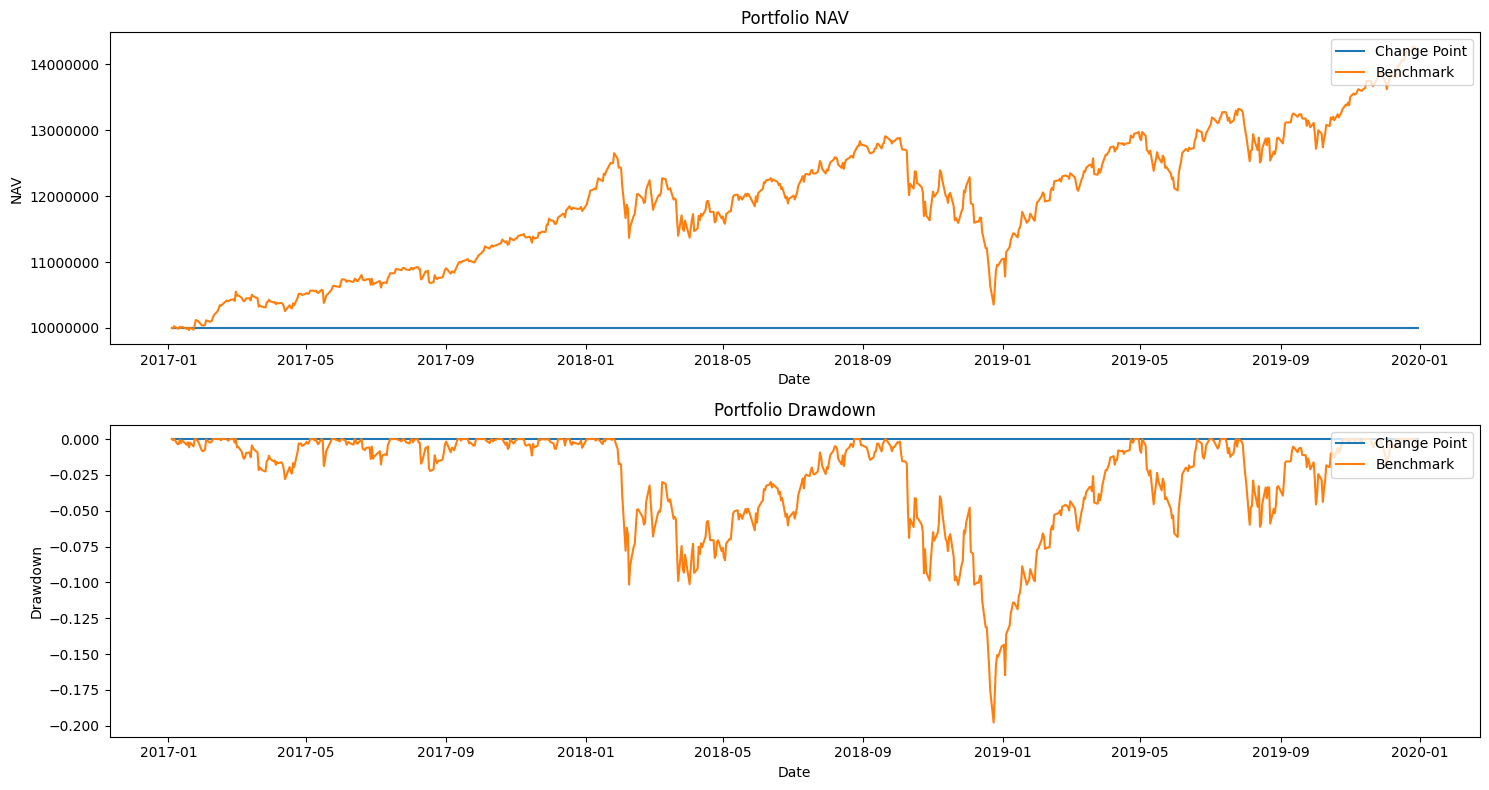

In [ ]:
trade_change_point_backtest = pd.DataFrame.from_dict(trade_change_point_dict, orient='index')
trade_change_point_backtest.columns = ['target_hedge_ratio', 'hedge_signal', 'current_hedge_ratio', 'vx_target_value', 'sp_target_value', 'vx_target_num', 'sp_mini_target_num', \
                                 'vx_position_num', 'sp_mini_position_num', 'vx_position_change', 'sp_mini_position_change', \
                                 'vx_position_value', 'sp_mini_position_value', 'cost', 'cash', 'portfolio_nav']
trade_change_point_backtest['portfolio_daily_dollar_return'] = trade_change_point_backtest['portfolio_nav'].diff()
trade_change_point_backtest['portfolio_daily_pct_return'] = trade_change_point_backtest['portfolio_nav'].diff() \
                                                        / trade_change_point_backtest['portfolio_nav'].shift(1)
drawdown_arr = []
for i in range(len(trade_change_point_backtest['portfolio_nav'])):
    max_nav = np.max(trade_change_point_backtest['portfolio_nav'][0:i+1])
    drawdown_arr.append(trade_change_point_backtest['portfolio_nav'][i]/max_nav - 1)
trade_change_point_backtest['portfolio_drawdown'] = drawdown_arr



num_sp_inception = initial_cap / trade_change_point_df.loc[trade_change_point_df.index[0]]['sp_close'] / 50
trade_change_point_backtest['benchmark_nav'] = num_sp_inception * trade_change_point_df['sp_close'] * 50
trade_change_point_backtest['benchmark_daily_dollar_return'] = trade_change_point_backtest['benchmark_nav'].diff()
trade_change_point_backtest['benchmark_daily_pct_return'] = trade_change_point_backtest['benchmark_nav'].diff() \
                                                        / trade_change_point_backtest['benchmark_nav'].shift(1)
drawdown_arr = []
for i in range(len(trade_change_point_backtest['benchmark_nav'])):
    max_nav = np.max(trade_change_point_backtest['benchmark_nav'][0:i+1])
    drawdown_arr.append(trade_change_point_backtest['benchmark_nav'][i]/max_nav - 1)
trade_change_point_backtest['benchmark_drawdown'] = drawdown_arr


trade_change_point_backtest.to_excel('Strategy Change Point Backtest.xlsx')

fig_4 = plt.figure(1, figsize=(15, 8))

chart9 = fig_4.add_subplot(211)
chart9.plot(trade_change_point_backtest['portfolio_nav'], label='Change Point')
chart9.plot(trade_change_point_backtest['benchmark_nav'], label='Benchmark')
chart9.set_ylabel('NAV')
chart9.set_xlabel('Date')
chart9.title.set_text('Portfolio NAV')
chart9.legend(loc='upper right', fontsize=10)
chart9.axes.ticklabel_format(style='plain', useOffset=False, axis='y')

chart10 = fig_4.add_subplot(212)
chart10.plot(trade_change_point_backtest['portfolio_drawdown'], label='Change Point')
chart10.plot(trade_change_point_backtest['benchmark_drawdown'], label='Benchmark')
chart10.set_ylabel('Drawdown')
chart10.set_xlabel('Date')
chart10.title.set_text('Portfolio Drawdown')
chart10.legend(loc='upper right', fontsize=10)
chart10.axes.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.tight_layout()

In [ ]:
## Assume riskfree rate euqals to the 10-yr treasury rate on 03 Jan 2017
rf = 0.0242

portfolio_cumulative_return = trade_change_point_backtest['portfolio_nav'][-1]/trade_change_point_backtest['portfolio_nav'][0] - 1
portfolio_geometric_return = (trade_change_point_backtest['portfolio_nav'][-1]/trade_change_point_backtest['portfolio_nav'][0]) ** \
                             (365 / len(trade_change_point_backtest['portfolio_nav'])) - 1
portfolio_volatility = trade_change_point_backtest['portfolio_daily_pct_return'][1:].std() * 16
portfolio_sharp = (portfolio_geometric_return - rf)/portfolio_volatility
portfolio_volatility_neg = trade_change_point_backtest['portfolio_daily_pct_return'][trade_change_point_backtest['portfolio_daily_pct_return'] < 0].std() * 16
portfolio_sortino = (portfolio_geometric_return - rf)/portfolio_volatility_neg
portfolio_max_drawdown = -1 * np.min(trade_change_point_backtest['portfolio_drawdown'])
portfolio_calmar = portfolio_geometric_return/portfolio_max_drawdown
portfolio_VaR_95 = -1 * np.percentile(trade_change_point_backtest['portfolio_daily_dollar_return'][1:], 5)
portfolio_VaR_99 = -1 * np.percentile(trade_change_point_backtest['portfolio_daily_dollar_return'][1:], 1)
portfolio_cVaR_95 = -1 * np.mean(trade_change_point_backtest['portfolio_daily_dollar_return'] \
                                 [trade_change_point_backtest['portfolio_daily_dollar_return'] < -1 * portfolio_VaR_95])
portfolio_cVaR_99 = -1 * np.mean(trade_change_point_backtest['portfolio_daily_dollar_return'] \
                                 [trade_change_point_backtest['portfolio_daily_dollar_return'] < -1 * portfolio_VaR_99])

portfolio_performance_measure = [portfolio_cumulative_return, portfolio_geometric_return, portfolio_volatility,
                                 portfolio_sharp, portfolio_volatility_neg, portfolio_sortino, portfolio_max_drawdown,
                                 portfolio_calmar, portfolio_VaR_95, portfolio_VaR_99, portfolio_cVaR_95, portfolio_cVaR_99]

benchmark_cumulative_return = trade_change_point_backtest['benchmark_nav'][-1]/trade_change_point_backtest['benchmark_nav'][0] - 1
benchmark_geometric_return = (trade_change_point_backtest['benchmark_nav'][-1]/trade_change_point_backtest['benchmark_nav'][0]) ** \
                             (365 / len(trade_change_point_backtest['benchmark_nav'])) - 1
benchmark_volatility = trade_change_point_backtest['benchmark_daily_pct_return'][1:].std() * 16
benchmark_sharp = (benchmark_geometric_return - rf)/benchmark_volatility
benchmark_volatility_neg = trade_change_point_backtest['benchmark_daily_pct_return'][trade_change_point_backtest['benchmark_daily_pct_return'] < 0].std() * 16
benchmark_sortino = (benchmark_geometric_return - rf)/benchmark_volatility_neg
benchmark_max_drawdown = -1 * np.min(trade_change_point_backtest['benchmark_drawdown'])
benchmark_calmar = benchmark_geometric_return/benchmark_max_drawdown
benchmark_VaR_95 = -1 * np.percentile(trade_change_point_backtest['benchmark_daily_dollar_return'][1:], 5)
benchmark_VaR_99 = -1 * np.percentile(trade_change_point_backtest['benchmark_daily_dollar_return'][1:], 1)
benchmark_cVaR_95 = -1 * np.mean(trade_change_point_backtest['benchmark_daily_dollar_return'] \
                                 [trade_change_point_backtest['benchmark_daily_dollar_return'] < -1 * benchmark_VaR_95])
benchmark_cVaR_99 = -1 * np.mean(trade_change_point_backtest['benchmark_daily_dollar_return'] \
                                 [trade_change_point_backtest['benchmark_daily_dollar_return'] < -1 * benchmark_VaR_99])

benchmark_performance_measure = [benchmark_cumulative_return, benchmark_geometric_return, benchmark_volatility,
                                 benchmark_sharp, benchmark_volatility_neg, benchmark_sortino, benchmark_max_drawdown,
                                 benchmark_calmar, benchmark_VaR_95, benchmark_VaR_99, benchmark_cVaR_95, benchmark_cVaR_99]

performance_measure_df = pd.DataFrame(portfolio_performance_measure)
performance_measure_df.columns = ['Change Point Strategy']
performance_measure_df.index = ['portfolio_cumulative_return', 'portfolio_geometric_return', 'portfolio_volatility',
                                'portfolio_sharp', 'portfolio_volatility_neg', 'portfolio_sortino', 'portfolio_max_drawdown',
                                'portfolio_calmar', 'portfolio_VaR_95', 'portfolio_VaR_99', 'portfolio_cVaR_95', 'portfolio_cVaR_99']
performance_measure_df['benchmark'] = benchmark_performance_measure
performance_measure_df

<ipython-input-60-353a5bad94fa>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_cumulative_return = trade_change_point_backtest['portfolio_nav'][-1]/trade_change_point_backtest['portfolio_nav'][0] - 1
<ipython-input-60-353a5bad94fa>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_geometric_return = (trade_change_point_backtest['portfolio_nav'][-1]/trade_change_point_backtest['portfolio_nav'][0]) ** \
<ipython-input-60-353a5bad94fa>:8: RuntimeWarning: divide by zero encountered in scalar divide
  portfolio_sharp = (portfolio_geometric_return - rf)/portfolio_volatility
<ipython-input-60-353a5bad94

,Change Point Strategy,benchmark
portfolio_cumulative_return,0.0,0.418602
portfolio_geometric_return,0.0,0.184974
portfolio_volatility,0.0,0.129172
portfolio_sharp,-inf,1.244654
portfolio_volatility_neg,NaN,0.111455
portfolio_sortino,NaN,1.442501
portfolio_max_drawdown,-0.0,0.197782
portfolio_calmar,NaN,0.935242
portfolio_VaR_95,-0.0,164284.927887
portfolio_VaR_99,-0.0,320092.480458
